In [ ]:
#default_exp datasets

# Dataset classes for training
These classes extend the pytorch `torch.utils.data.Dataset` class, and output tuples of dictionaries containing `(model_input, ground_truth)` 

In [ ]:
#export
from surfbreak import graphutils, supervision
import pipelines
import graphchain
import dask
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

def normalize_tensor(tensor, clip_max=1):
    return ((tensor - tensor.mean()) / tensor.std()).clip(max=clip_max)

def get_wavefront_tensor_txy(ydim_out, slice_xrange=(30,90), output_dim=3, start_s=0, duration_s=30, time_axis_scale=0.5,
                             target_graph_key="result"):
    """Supplying target_traph_key='clipped_image_tensor' will give an equivalently scaled version of the raw video instead """

    # Get a little more than the required duration, then clip to the appropriate length 
    # (pre-processing with delta-time result 2 less samples)
    SAMPLING_HZ = 10 #(defined within preprocessing pipeline steps)
    waveform_slice_graph = pipelines.video_to_waveform_slice('./tmp/shirahama_1590387334_SURF-93cm.ts',
                                                                duration_s=duration_s+1, start_s=start_s,
                                                                slice_xrange=slice_xrange, output_dim=output_dim)
    waveform_array_yxt = graphchain.get(waveform_slice_graph, target_graph_key)[:,:,:duration_s*SAMPLING_HZ]        

    assert waveform_array_yxt.shape[2] == duration_s*SAMPLING_HZ

    # Reshape to the standard channel axis order for learning (T, X, Y)
    waveform_array_txy = np.transpose(waveform_array_yxt, (2,1,0))
    
    # Incredibly important to clip the large peak values in this raw waveform_array, 
    # since it's mostly a binary indicator of where a wave-foam front was detected
    waveform_tensor = torch.from_numpy(normalize_tensor(waveform_array_txy, clip_max=1.))
    tdim_in, xdim_in, ydim_in = waveform_tensor.shape 
    xdim_out = int(ydim_out * (xdim_in / ydim_in))
    tdim_out = int(duration_s * SAMPLING_HZ * time_axis_scale)
    
    # [None, None,...] nonsense below is adding and removing [batch, channel] dimensions required by F.interpolate
    resized_tensor = F.interpolate(waveform_tensor[None,None,...], size=(tdim_out, xdim_out, ydim_out),
                                   mode='trilinear', align_corners=False)
    
    return resized_tensor[0,0,...]


torch.Size([100, 62, 150])
torch.Size([100, 62, 150])


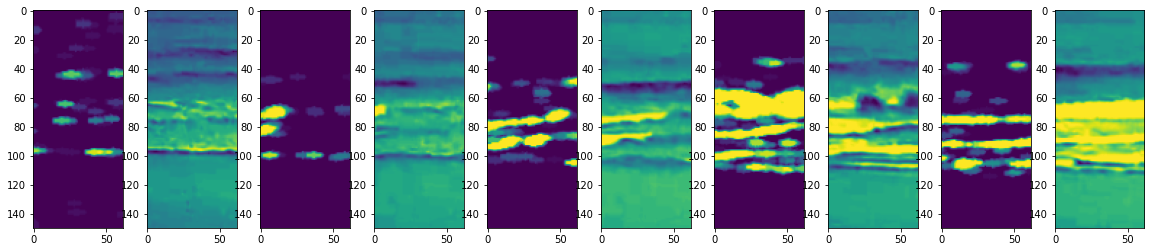

In [ ]:
param_dict = dict(ydim_out=150, slice_xrange=(30,90), output_dim=3, start_s=0, duration_s=20, time_axis_scale=0.5)
wf_tensor_txy = get_wavefront_tensor_txy(**param_dict)
tdim, xdim, ydim = wf_tensor_txy.shape
print(wf_tensor_txy.shape)
assert tdim == int(param_dict['duration_s'] * 10 * param_dict['time_axis_scale']) # code assumes 10hz signal input
assert ydim == param_dict["ydim_out"]

vid_tensor_txy = get_wavefront_tensor_txy(**param_dict, target_graph_key='clipped_image_tensor')
print(vid_tensor_txy.shape)

assert wf_tensor_txy.shape == vid_tensor_txy.shape

n_plots=5
fig, axes = plt.subplots(ncols=2*n_plots, figsize=(20,4))
for i in range(n_plots):
    axes[ i*2 ].imshow(wf_tensor_txy[0+10*i].T)
    axes[i*2+1].imshow(vid_tensor_txy[0+10*i].T)

In [ ]:
#export
def get_mgrid(sidelen_tuple, tcoord_range=None):
    '''Generates a flattened grid of (t,x,y) coordinates in a range of -1 to 1.
    sidelen_tuple: tuple of coordinate side lengths (t,x,y)
    '''
    if tcoord_range is None:
        tensors = tuple([torch.linspace(-1, 1, steps=sidelen_tuple[0]),
                         torch.linspace(-1, 1, steps=sidelen_tuple[1]),
                         torch.linspace(-1, 1, steps=sidelen_tuple[2])])
    else:
        tensors = tuple([torch.linspace(*tcoord_range, steps=sidelen_tuple[0]),
                         torch.linspace(-1, 1, steps=sidelen_tuple[1]),
                         torch.linspace(-1, 1, steps=sidelen_tuple[2])])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, len(sidelen_tuple))
    return mgrid


class WaveformVideoDataset(Dataset):
    def __init__(self, ydim, xrange=(30,90), timerange=(0,61), time_chunk_duration_s=30, time_chunk_stride_s=15, time_axis_scale=0.5):
        super().__init__()
        start_s, end_s = timerange
        self.ydim = ydim
        self.xrange = xrange
        self.time_axis_scale = time_axis_scale
        self.time_chunk_duration_s = time_chunk_duration_s
        self.time_chunk_stride_s = time_chunk_stride_s
        self.t_coords_per_second = 10 * time_axis_scale
        
        self.video_chunk_timeranges = np.array(list((start, start+time_chunk_duration_s) for start in
                                                    range(start_s, end_s - time_chunk_duration_s, time_chunk_stride_s)))

    def __len__(self):
        return len(self.video_chunk_timeranges)

    def __getitem__(self, idx):
        item_start_s, item_end_s = self.video_chunk_timeranges[idx]
        full_wf_tensor = get_wavefront_tensor_txy(self.ydim, slice_xrange=self.xrange, output_dim=3, 
                                              start_s=item_start_s, duration_s=(item_end_s - item_start_s), 
                                              time_axis_scale=self.time_axis_scale, target_graph_key="result")
        full_vid_tensor = get_wavefront_tensor_txy(self.ydim, slice_xrange=self.xrange, output_dim=3, 
                                              start_s=item_start_s, duration_s=(item_end_s - item_start_s), 
                                              time_axis_scale=self.time_axis_scale, target_graph_key="clipped_image_tensor")
        
        # For now, abstract time coordinates will be in centered minutes (so a 2 minute video spans -1 to 1, and a 30 minute video spans -15 to 15)
        full_duration_s = self.video_chunk_timeranges.max() - self.video_chunk_timeranges.min()
        full_tcoord_range = -((full_duration_s/60) / 2), ((full_duration_s/60) / 2)
 
        this_chunk_tcoord_range = [self.video_chunk_timeranges[idx][0]/60 - full_tcoord_range[1],
                                   self.video_chunk_timeranges[idx][1]/60 - full_tcoord_range[1]]

        
        all_coords = get_mgrid(full_wf_tensor.shape, tcoord_range=this_chunk_tcoord_range)
        
                
        model_input = {
            'all_coords':all_coords.reshape(-1,3)
        }
        
        assert full_vid_tensor.shape == full_wf_tensor.shape
        ground_truth = {
            "all_video_values": full_vid_tensor.reshape(-1,1),
            "all_wavefront_values": full_wf_tensor.reshape(-1,1),
            "full_tensor_shape": full_vid_tensor.shape,
            "timerange": (item_start_s, item_end_s),
            
        }
        return model_input, ground_truth
        

Input parameters:  {'ydim': 120, 'xrange': (30, 91), 'timerange': (0, 73), 'time_chunk_duration_s': 30, 'time_chunk_stride_s': 15, 'time_axis_scale': 0.5}
Coordinates shape   (n,c):  torch.Size([900000, 3])
Output tensor shape (n,c):  torch.Size([900000, 1])
Output tensor shape (t,x,y):  torch.Size([150, 50, 120])
Visualization of data and then coordinates values for (t, x, y):


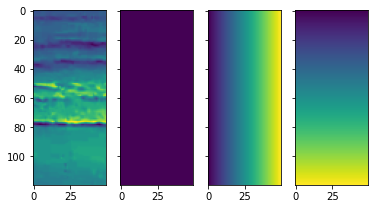

In [ ]:
param_dict = dict(ydim=120, xrange=(30,91), timerange=(0,73), time_chunk_duration_s=30, time_chunk_stride_s=15, 
                  time_axis_scale=0.5)
print("Input parameters: ",param_dict)
wf_dataset = WaveformVideoDataset(**param_dict)

model_input, gt = wf_dataset[0]
print("Coordinates shape   (n,c): ", model_input['all_coords'].shape)
assert model_input['all_coords'].shape[0] == gt['all_wavefront_values'].shape[0] 
assert model_input['all_coords'].shape[1] == 3

wf_tensor = gt['all_wavefront_values']
wf_tensor_txy = wf_tensor.reshape(gt['full_tensor_shape'])
print("Output tensor shape (n,c): ",wf_tensor.shape)
print("Output tensor shape (t,x,y): ",wf_tensor_txy.shape)
assert wf_tensor_txy.shape[0] == int(param_dict['time_chunk_duration_s']*param_dict['time_axis_scale'])*10 # Correct length assuming 10hz video parsing
assert gt['timerange'][1] - gt['timerange'][0] == param_dict['time_chunk_duration_s']

vid_tensor = gt['all_video_values']
vid_tensor_txy = vid_tensor.reshape(gt['full_tensor_shape'])
assert vid_tensor.shape == wf_tensor.shape

all_coords = model_input['all_coords']
all_coords_txy = all_coords.reshape(*wf_tensor_txy.shape, 3)
assert all_coords_txy.shape[:3] == wf_tensor_txy.shape

print("Visualization of data and then coordinates values for (t, x, y):")
fig, axes = plt.subplots(ncols=4, sharey=True)
axes[0].imshow(vid_tensor_txy[0].T)
for idx in range(3):
    axes[idx+1].imshow(all_coords_txy[0][:,:,idx].T)

In [ ]:
for timerange in [(0,60), (10,71), (0,99)]:
    duration = 30
    stride = 15
    param_dict = dict(ydim=120, xrange=(30,90), timerange=timerange, time_chunk_duration_s=duration, time_chunk_stride_s=stride, 
                      time_axis_scale=0.5)

    wf_dataset = WaveformVideoDataset(**param_dict)
    for chunk_timerange in wf_dataset.video_chunk_timeranges:
        assert chunk_timerange[1] - chunk_timerange[0] == duration
    print("range: ",timerange, "  stride: ",stride,'  chunk_timeranges:', wf_dataset.video_chunk_timeranges)

range:  (0, 60)   stride:  15   chunk_timeranges: [[ 0 30]
 [15 45]]
range:  (10, 71)   stride:  15   chunk_timeranges: [[10 40]
 [25 55]
 [40 70]]
range:  (0, 99)   stride:  15   chunk_timeranges: [[ 0 30]
 [15 45]
 [30 60]
 [45 75]
 [60 90]]


#### Some simple visual tests to confirm alignment between strided chunks
The middle two rows of the plots below should match (but with some differences due to chunk-based normalization)

torch.Size([20, 49, 120])
torch.Size([20, 49, 120])


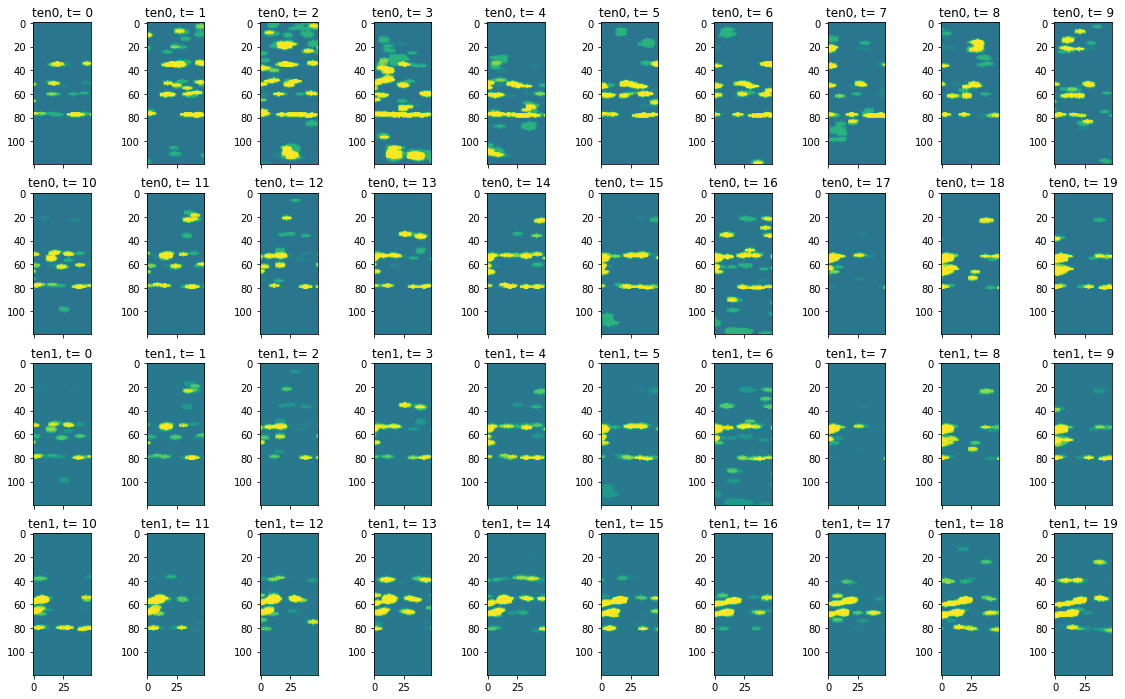

In [ ]:
param_dict = dict(ydim=120, xrange=(30,90), timerange=(0,60), time_chunk_duration_s=2, time_chunk_stride_s=1, time_axis_scale=1)
wf_dataset = WaveformVideoDataset(**param_dict)
in0, gt0 = wf_dataset[0]
in1, gt1 = wf_dataset[1]
tensor0 = gt0['all_wavefront_values'].reshape(gt0['full_tensor_shape'])
tensor1 = gt1['all_wavefront_values'].reshape(gt1['full_tensor_shape'])

print(tensor0.shape)
print(tensor1.shape)
n_times = tensor0.shape[0]//2
fig, axes = plt.subplots(ncols=n_times, nrows=4, figsize=(2*n_times, 12), sharex=True)
for idx in range(n_times):
    axes[0][idx].set_title("ten0, t= "+str(idx))
    axes[0][idx].imshow(tensor0[idx].T, vmin=-1, vmax=1)
    axes[1][idx].set_title("ten0, t= "+str(idx+n_times))
    axes[1][idx].imshow(tensor0[idx+n_times].T, vmin=-1, vmax=1)
    
    axes[2][idx].set_title("ten1, t= "+str(idx))
    axes[2][idx].imshow(tensor1[idx].T, vmin=-1, vmax=1)
    axes[3][idx].set_title("ten1, t= "+str(idx+n_times))
    axes[3][idx].imshow(tensor1[idx+n_times].T, vmin=-1, vmax=1)

# Develop another dataset which iterates over subsamples of a single video chunk

In [ ]:
#export        
def subsample_strided_buckets(txyc_tensor, bucket_sidelength, samples_per_bucket=100,
                              return_xy_buckets=False, sample_offset=0):
    """Samples channel values form yxt tensors along bucketed spatial (x,y) dimensions.
       Leaves the time dimension the same. Return a tensor of dimensions (time, channel, buckets, samples)
       Input:  tensor (time, x, y, channels)
       Output: tensor (bucket, samples, time, channels) 
               OR (x,y,s,t,c) if return_xy_buckets=True
       
       Only samples from the first element in the batch
       if return_xy_buckets=True, buckets are indexed by x and ycoordinates"""
    
    tcxy_tensor = txyc_tensor.permute(0,3,1,2)    
    tdim, cdim, xdim, ydim = tcxy_tensor.shape 
    stride = bucket_sidelength
    
    # Fold: Expands a rolling window of kernel_size, with overlap between windows if stride < kernel_size
    #       input tensor of shape (N,C,T) , where N is the batch dimension, C is the channel dimension, 
    #       and * represent arbitrary spatial dimensions
    #          See https://pytorch.org/docs/master/generated/torch.nn.Unfold.html#torch.nn.Unfold
    uf = F.unfold(tcxy_tensor,kernel_size=bucket_sidelength, stride=stride)
    n_buckets = uf.shape[-1]
    tcsb = uf.reshape(tdim, cdim, -1, n_buckets)
    n_total_samples = tcsb.shape[2]
    
    subsample_stride = n_total_samples//samples_per_bucket
    offset_idx = sample_offset%subsample_stride
    tcsb_sampled = tcsb[...,:offset_idx + samples_per_bucket*subsample_stride:subsample_stride,:]
    
    if return_xy_buckets:
        tcsxy = tcsb_sampled.reshape(tdim, cdim, tcsb_sampled.shape[2], xdim//stride, ydim//stride)
        xystc = tcsxy.permute(3,4,2,0,1)
        return xystc 
    else:
        bstc = tcsb_sampled.permute(3,2,0,1)
        return bstc

class WaveformChunkDataset(Dataset):
    def __init__(self, wf_video_dataset, video_index=0, xy_bucket_sidelen=20, samples_per_xy_bucket=10, time_sample_interval=4,
                 steps_per_video_chunk=1000):
        self.wf_video_dataset = wf_video_dataset
        self.video_index = video_index
        self.xy_bucket_sidelen = xy_bucket_sidelen
        self.samples_per_xy_bucket = samples_per_xy_bucket
        self.time_sample_interval = time_sample_interval
        self.steps_per_video_chunk = steps_per_video_chunk

    def __len__(self):
        return len(self.wf_video_dataset) * self.steps_per_video_chunk
    
    def __getitem__(self, idx):
        
        video_idx = int(idx // self.steps_per_video_chunk)
        t_idx = idx % self.steps_per_video_chunk
        
        model_input, ground_truth = self.wf_video_dataset[self.video_index]
        full_tensor_shape = ground_truth['full_tensor_shape']
        all_wf_values_txyc = ground_truth['all_wavefront_values'].reshape(*full_tensor_shape, 1)
        all_coords_txyc = model_input['all_coords'].reshape(*full_tensor_shape, 3)

        xy_subsampled_wf_values_bstc = subsample_strided_buckets(all_wf_values_txyc,
                                                                 bucket_sidelength=self.xy_bucket_sidelen,
                                                                 samples_per_bucket=self.samples_per_xy_bucket,
                                                                 sample_offset=t_idx)
        xy_subsampled_coords_bstc =    subsample_strided_buckets(all_coords_txyc,
                                                                 bucket_sidelength=self.xy_bucket_sidelen,
                                                                 samples_per_bucket=self.samples_per_xy_bucket,
                                                                 sample_offset=t_idx)
        
        ti = self.time_sample_interval
        
        subsampled_wf_values_bstc = xy_subsampled_wf_values_bstc[:,:,t_idx%ti::ti,:]        
        subsampled_coords_bstc =       xy_subsampled_coords_bstc[:,:,t_idx%ti::ti,:]
        
        model_input = {
            'coords': subsampled_coords_bstc.reshape(-1, 3)
        }
        
        assert subsampled_wf_values_bstc.shape[:3] == subsampled_coords_bstc.shape[:3]
        
        ground_truth = {
            "wavefront_values": subsampled_wf_values_bstc.reshape(-1,1),
            "bst_shape": subsampled_wf_values_bstc.shape[:3],
            "timerange": ground_truth['timerange'],
            'time_sampling_offset': t_idx%ti

        }
        
        return model_input, ground_truth
        

In [ ]:
param_dict = dict(ydim=120, xrange=(30,91), timerange=(0,60), time_chunk_duration_s=30, time_chunk_stride_s=15, 
                  time_axis_scale=0.5)
print("Input parameters: ",param_dict)
wf_dataset = WaveformVideoDataset(**param_dict)

chunk_params = dict(xy_bucket_sidelen=20, samples_per_xy_bucket=100, time_sample_interval=5)
chunk_dataset = WaveformChunkDataset(wf_dataset, **chunk_params)

for n in range(10):
    inputs, gt = chunk_dataset[n]
    assert inputs['coords'].shape[1] == 3
    assert inputs['coords'].shape[0] == gt['wavefront_values'].shape[0]
    # bstc dimensions are (xy_batch, samples per batch, time, channel)
    bstc_coords = inputs['coords'].reshape(*gt['bst_shape'],3)
    bstc_wf_val = gt['wavefront_values'].reshape(*gt['bst_shape'], 1)
    assert bstc_coords.shape[1] == chunk_params['samples_per_xy_bucket']

    assert bstc_coords.shape[:3] == bstc_wf_val.shape[:3]
print('coords: ',inputs['coords'].shape)
print('wf_val: ', gt['wavefront_values'].shape)


print("time_sampling_offset: ", gt['time_sampling_offset'])
print('coords bstc: ', bstc_coords.shape)
print('wf_val bstc: ', bstc_wf_val.shape)


Input parameters:  {'ydim': 120, 'xrange': (30, 91), 'timerange': (0, 60), 'time_chunk_duration_s': 30, 'time_chunk_stride_s': 15, 'time_axis_scale': 0.5}
coords:  torch.Size([36000, 3])
wf_val:  torch.Size([36000, 1])
time_sampling_offset:  4
coords bstc:  torch.Size([12, 100, 30, 3])
wf_val bstc:  torch.Size([12, 100, 30, 1])


2000